In [23]:
from pyoxigraph import *
from sklearn.covariance import OAS
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from utils import *
from Ressources import *
from Ontology import *
from decomposition import *
from pprint import pprint
from itertools import combinations

In [24]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [25]:
def embed_label(target_phrase, sentence):
    
    encoded = tokenizer(sentence, return_tensors="pt", add_special_tokens=False)
    sent_tokens = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])
    target_tokens = tokenizer.tokenize(target_phrase)
    target_positions = []
    for i in range(len(sent_tokens) - len(target_tokens) + 1):
        if sent_tokens[i : i + len(target_tokens)] == target_tokens:
            target_positions.extend(range(i, i + len(target_tokens)))
    if len(target_positions) == 0:
        raise ValueError(f"Phrase '{target_phrase}' not found in tokenized sentence.")
    with torch.no_grad():
        outputs = model(**encoded)
    hidden = outputs.last_hidden_state
    word_embedding = hidden[0, target_positions, :].mean(dim=0)

    return word_embedding

def oas(word, sentences):
    embeddings = [embed_label(word, s) for s in sentences]
    stacked = torch.stack(embeddings)
    data = np.array(embeddings)
    oas = OAS()
    return stacked, oas.fit(data)

def fit_pca(oas : OAS):
    var = oas.covariance_
    var_t = torch.from_numpy(var).float()
    M, D, V = torch.linalg.svd(var_t)
    return V[:2].T.cpu().numpy()

def project_mean_and_cov(mu: torch.Tensor, cov: torch.Tensor, W: torch.Tensor):
    mu_2d = W.T @ mu
    cov_2d = W.T @ cov @ W
    return mu_2d, cov_2d

def get_ellipsis(word : str, sentences : list):
    embeddings, oac = oas(word, sentences)
    mean = embeddings.mean(dim=0).cpu().numpy()
    pca = fit_pca(oac)
    return project_mean_and_cov(mean, oac.covariance_, pca)

def covariance_to_ellipse_params(cov_2d: torch.Tensor, n_std=1.0):
    eigvals, eigvecs = torch.linalg.eigh(cov_2d)
    idx = torch.argsort(eigvals, descending=True)
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    width, height = 2 * n_std * torch.sqrt(eigvals)
    angle = torch.atan2(eigvecs[1, 0], eigvecs[0, 0]) * (180.0 / torch.pi)
    return width.item(), height.item(), angle.item()


def plot_region(mu_2d, cov_2d, label=None, n_std=1.0, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))

    width, height, angle = covariance_to_ellipse_params(torch.from_numpy(cov_2d), n_std)
    ellipse = Ellipse(
        xy=mu_2d,
        width=width,
        height=height,
        angle=angle,
        edgecolor='blue',
        facecolor = "none",
        alpha=0.4
    )
    ax.add_patch(ellipse)
    ax.scatter(mu_2d[0], mu_2d[1], c='red', s=30)
    if label:
        ax.text(mu_2d[0], mu_2d[1], f" {label}", fontsize=12)
    ax.set_aspect('equal', 'box')
    ax.grid(True)
    return ax

## Initialisation

In [26]:
file = "../test/bfo-core.ttl"
bfo = Ontology.load(file)
hierarchy = bfo.format_hierarchy()
pprint(hierarchy)

{'http://purl.obolibrary.org/obo/BFO_0000001': ['http://purl.obolibrary.org/obo/BFO_0000003',
                                                'http://purl.obolibrary.org/obo/BFO_0000002'],
 'http://purl.obolibrary.org/obo/BFO_0000002': ['http://purl.obolibrary.org/obo/BFO_0000031',
                                                'http://purl.obolibrary.org/obo/BFO_0000020',
                                                'http://purl.obolibrary.org/obo/BFO_0000004'],
 'http://purl.obolibrary.org/obo/BFO_0000003': ['http://purl.obolibrary.org/obo/BFO_0000035',
                                                'http://purl.obolibrary.org/obo/BFO_0000015',
                                                'http://purl.obolibrary.org/obo/BFO_0000011',
                                                'http://purl.obolibrary.org/obo/BFO_0000008'],
 'http://purl.obolibrary.org/obo/BFO_0000004': ['http://purl.obolibrary.org/obo/BFO_0000141',
                                                'http://p

In [27]:
ellipsis_dict = {}
disjoint_pairs = []
for dis in bfo.allDisjointsList:
    iris = [d.iri for d in dis]
    pairs = list(combinations(iris, 2))
    disjoint_pairs += pairs
    
pprint(disjoint_pairs)

[('http://purl.obolibrary.org/obo/BFO_0000142',
  'http://purl.obolibrary.org/obo/BFO_0000146'),
 ('http://purl.obolibrary.org/obo/BFO_0000142',
  'http://purl.obolibrary.org/obo/BFO_0000147'),
 ('http://purl.obolibrary.org/obo/BFO_0000146',
  'http://purl.obolibrary.org/obo/BFO_0000147'),
 ('http://purl.obolibrary.org/obo/BFO_0000009',
  'http://purl.obolibrary.org/obo/BFO_0000018'),
 ('http://purl.obolibrary.org/obo/BFO_0000009',
  'http://purl.obolibrary.org/obo/BFO_0000026'),
 ('http://purl.obolibrary.org/obo/BFO_0000009',
  'http://purl.obolibrary.org/obo/BFO_0000028'),
 ('http://purl.obolibrary.org/obo/BFO_0000018',
  'http://purl.obolibrary.org/obo/BFO_0000026'),
 ('http://purl.obolibrary.org/obo/BFO_0000018',
  'http://purl.obolibrary.org/obo/BFO_0000028'),
 ('http://purl.obolibrary.org/obo/BFO_0000026',
  'http://purl.obolibrary.org/obo/BFO_0000028'),
 ('http://purl.obolibrary.org/obo/BFO_0000008',
  'http://purl.obolibrary.org/obo/BFO_0000011'),
 ('http://purl.obolibrary.org/

[]

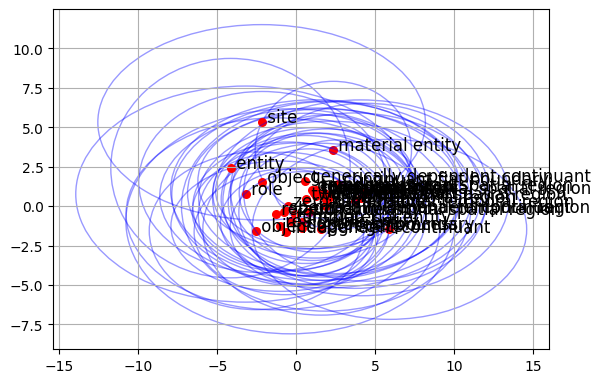

In [28]:
figs, axs = plt.subplots()
axs.grid(False)
for c in bfo.named_classes:
    for d in c.disjoints:
        disjoint_pairs.append((c.iri, d.iri))
    label, sentences = c.create_sentences()
    center, cov = get_ellipsis(label, sentences)
    ellipsis_dict[c.iri] = center, cov
    plot_region(center, cov, label=str(c), n_std=2.0, ax=axs)
plt.plot()

## Optimization

In [34]:
optimized = optimize_hierarchy_adaptive(ellipsis_dict,  
                                        bfo.format_hierarchy(), 
                                        disjoint_pairs, 
                                        lr = 3e-2,
                                        lr_factor = 0.5,
                                        target_loss=.000001)

[step 200] loss = 8439.4668 | lr = 0.030000
[step 400] loss = 3335.6528 | lr = 0.030000
[step 600] loss = 1576.8376 | lr = 0.030000
[step 800] loss = 861.6512 | lr = 0.030000
[step 1000] loss = 485.8491 | lr = 0.030000
[step 1200] loss = 267.6476 | lr = 0.030000
[step 1400] loss = 136.6472 | lr = 0.030000
[step 1600] loss = 56.0923 | lr = 0.030000
[step 1800] loss = 6.4315 | lr = 0.030000
final loss = -0.3229 at iteration 1834


[]

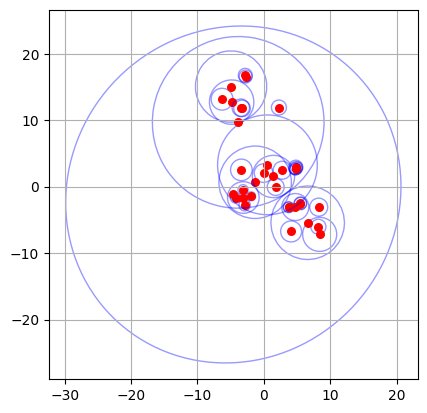

In [35]:
figs, axs = plt.subplots()
axs.grid(False)
for k, v in optimized.items():
    mu_2d = v.mu.detach().cpu().numpy()
    cov_2d = v.cov.detach().cpu().numpy()
    plot_region(mu_2d, cov_2d, n_std=2.0, ax=axs)
plt.plot()

[]

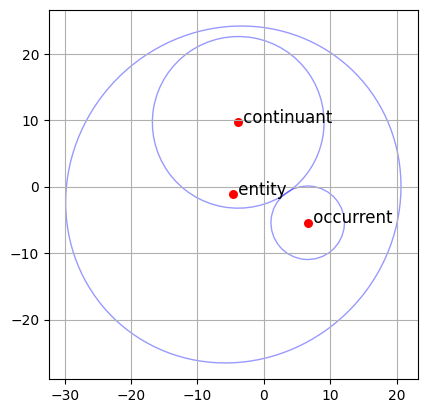

In [36]:
figs, axs = plt.subplots()
for k, v in optimized.items():
    class_e = NamedClass(iri = k, store = bfo.store)
    if class_e.iri == "http://purl.obolibrary.org/obo/BFO_0000001" or class_e.iri == "http://purl.obolibrary.org/obo/BFO_0000002" or class_e.iri == "http://purl.obolibrary.org/obo/BFO_0000003":
        mu_2d = v.mu.detach().cpu().numpy()
        cov_2d = v.cov.detach().cpu().numpy()
        plot_region(mu_2d, cov_2d, label = str(NamedClass(iri = k, store = bfo.store)), n_std=2.0, ax=axs)
        
plt.plot()

[]

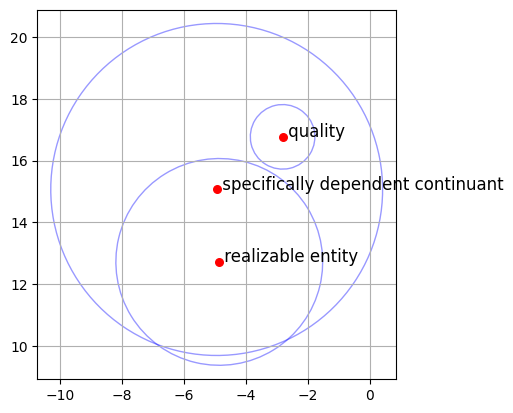

In [37]:
figs, axs = plt.subplots()
for k, v in optimized.items():
    class_e = NamedClass(iri = k, store = bfo.store)
    if class_e.iri == "http://purl.obolibrary.org/obo/BFO_0000017" or class_e.iri == "http://purl.obolibrary.org/obo/BFO_0000020" or class_e.iri == "http://purl.obolibrary.org/obo/BFO_0000019":
        mu_2d = v.mu.detach().cpu().numpy()
        cov_2d = v.cov.detach().cpu().numpy()
        plot_region(mu_2d, cov_2d, label = str(NamedClass(iri = k, store = bfo.store)), n_std=2.0, ax=axs)
        
plt.plot()

[]

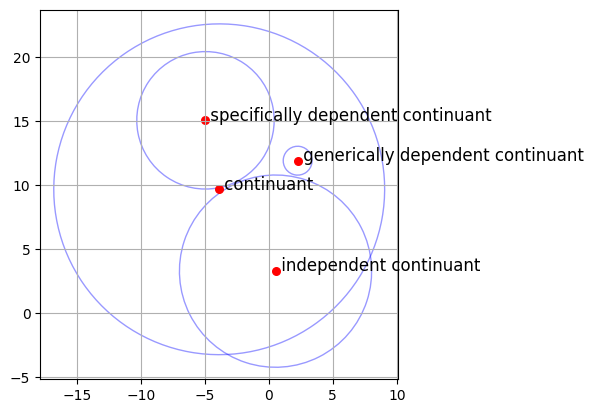

In [38]:
figs, axs = plt.subplots()
for k, v in optimized.items():
    class_e = NamedClass(iri = k, store = bfo.store)
    if class_e.iri == "http://purl.obolibrary.org/obo/BFO_0000002" or class_e.iri == "http://purl.obolibrary.org/obo/BFO_0000031" or class_e.iri == "http://purl.obolibrary.org/obo/BFO_0000004" or class_e.iri == "http://purl.obolibrary.org/obo/BFO_0000020":
        mu_2d = v.mu.detach().cpu().numpy()
        cov_2d = v.cov.detach().cpu().numpy()
        plot_region(mu_2d, cov_2d, label = str(NamedClass(iri = k, store = bfo.store)), n_std=2.0, ax=axs)
        
plt.plot()